# Import von Bibliotheken

In [78]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Download der Daten

In [79]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

## Datenvorverarbeitung

In [80]:
# Datenformat: Pandas Dataframe
df = pd.read_csv(csv_path)

# Stündliche Daten
df = df[5::6]
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df = df.resample('60min').mean()

# Extraktion der Temperatur-Zeitreihe
temp = df['T (degC)']
temp = temp.fillna(method='backfill')

temp.isna().sum()

0

## Enfernen von saisonaler Struktur

In [81]:
seasonal_lag = temp.shift(365*24)
temp = temp - seasonal_lag
temp = temp.dropna()

# Test auf Stationarität
def check_stationarity(series):
    # Von: https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(temp)

ADF Statistic: -16.835576
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


### Optional: Erstellung von Zufallsdaten

In [82]:
'''
np.random.seed(1)

l = len(temp)
start = temp[0]
sim = temp.copy()

for i in range(l):
    if i ==0:
        sim[i] = start
    if i>0:
        sim[i]=sim[i-1] + np.random.normal(loc=0, scale=1)


sim = sim-np.min(sim)+10
plt.plot(sim)
temp = sim
'''

'\nnp.random.seed(1)\n\nl = len(temp)\nstart = temp[0]\nsim = temp.copy()\n\nfor i in range(l):\n    if i ==0:\n        sim[i] = start\n    if i>0:\n        sim[i]=sim[i-1] + np.random.normal(loc=0, scale=1)\n\n\nsim = sim-np.min(sim)+10\nplt.plot(sim)\ntemp = sim\n'

## Explorative Datenanalyse

### Visualisierung der Zeitreihe

Text(0, 0.5, 'Häufigkeit')

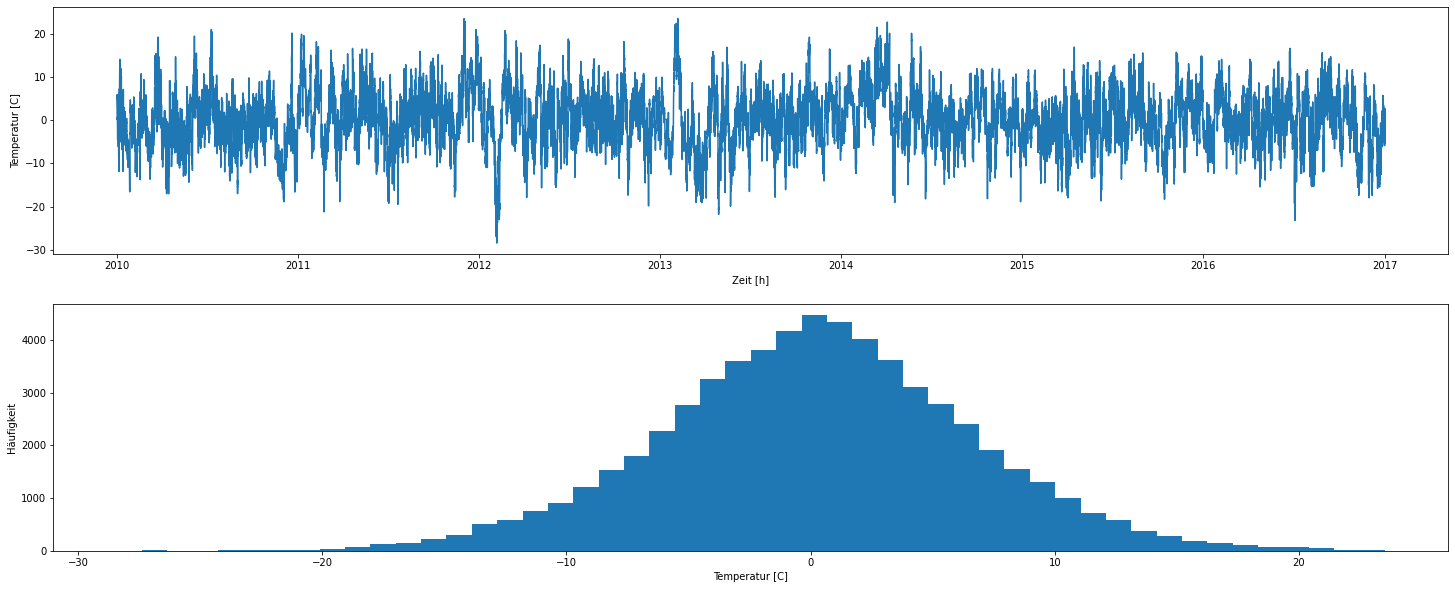

In [83]:

fig, ax = plt.subplots(2,figsize=(25,10))

ax[0].plot(temp)
ax[0].set_xlabel('Zeit [h]')
ax[0].set_ylabel('Temperatur [C]')
ax[1].hist(temp,bins=50)
ax[1].set_xlabel('Temperatur [C]')
ax[1].set_ylabel('Häufigkeit')

### Visualisierung von zeitlichen Abhängigkeitsstrukturen

Text(0, 0.5, 'Temperatur(t-9)')

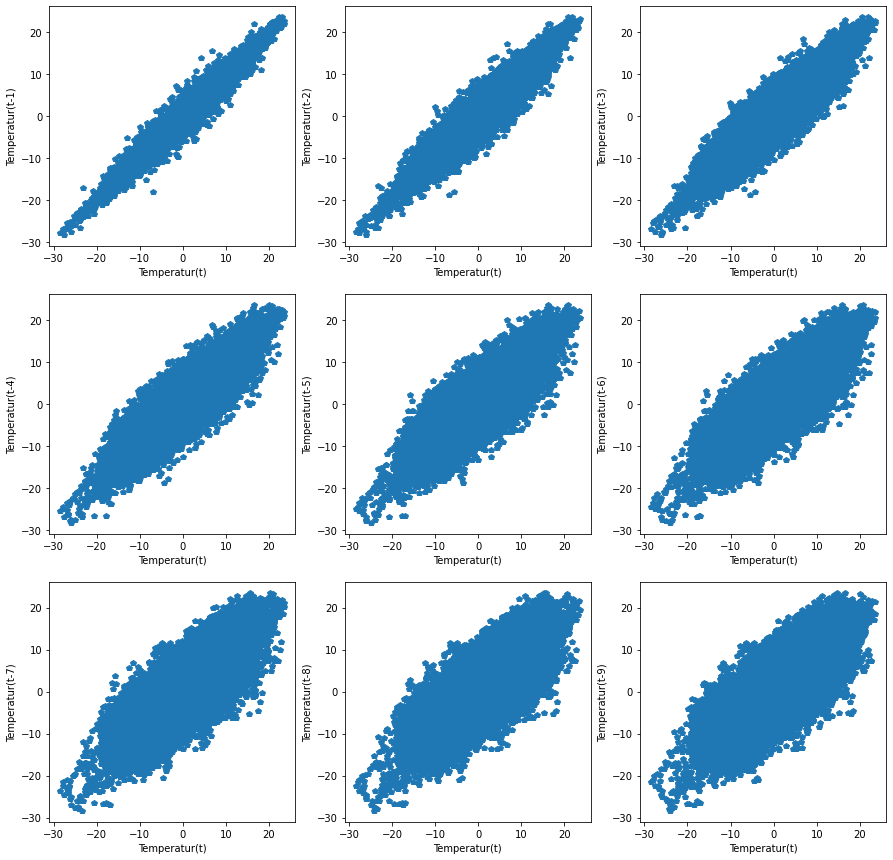

In [84]:
temp_lag1 = temp.shift(1)
temp_lag2 = temp.shift(2)
temp_lag3 = temp.shift(3)
temp_lag4 = temp.shift(4)
temp_lag5 = temp.shift(5)
temp_lag6 = temp.shift(6)
temp_lag7 = temp.shift(7)
temp_lag8 = temp.shift(8)
temp_lag9 = temp.shift(9)

fig, ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].plot(temp, temp_lag1,'p')
ax[0,0].set_xlabel('Temperatur(t)')
ax[0,0].set_ylabel('Temperatur(t-1)')
ax[0,1].plot(temp, temp_lag2,'p')
ax[0,1].set_xlabel('Temperatur(t)')
ax[0,1].set_ylabel('Temperatur(t-2)')
ax[0,2].plot(temp, temp_lag3,'p')
ax[0,2].set_xlabel('Temperatur(t)')
ax[0,2].set_ylabel('Temperatur(t-3)')
ax[1,0].plot(temp, temp_lag4,'p')
ax[1,0].set_xlabel('Temperatur(t)')
ax[1,0].set_ylabel('Temperatur(t-4)')
ax[1,1].plot(temp, temp_lag5,'p')
ax[1,1].set_xlabel('Temperatur(t)')
ax[1,1].set_ylabel('Temperatur(t-5)')
ax[1,2].plot(temp, temp_lag6,'p')
ax[1,2].set_xlabel('Temperatur(t)')
ax[1,2].set_ylabel('Temperatur(t-6)')
ax[2,0].plot(temp, temp_lag7,'p')
ax[2,0].set_xlabel('Temperatur(t)')
ax[2,0].set_ylabel('Temperatur(t-7)')
ax[2,1].plot(temp, temp_lag8,'p')
ax[2,1].set_xlabel('Temperatur(t)')
ax[2,1].set_ylabel('Temperatur(t-8)')
ax[2,2].plot(temp, temp_lag9,'p')
ax[2,2].set_xlabel('Temperatur(t)')
ax[2,2].set_ylabel('Temperatur(t-9)')

## Umwandlung der Daten in rollierende Zeitfenster

In [85]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [86]:
# Definition der Länge der Zeitfenster
WINDOW_SIZE = 50
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((61317, 50, 1), (61317,))

## Experimentelles Setup: Trainingsdaten, Validierungsaten und Testdaten

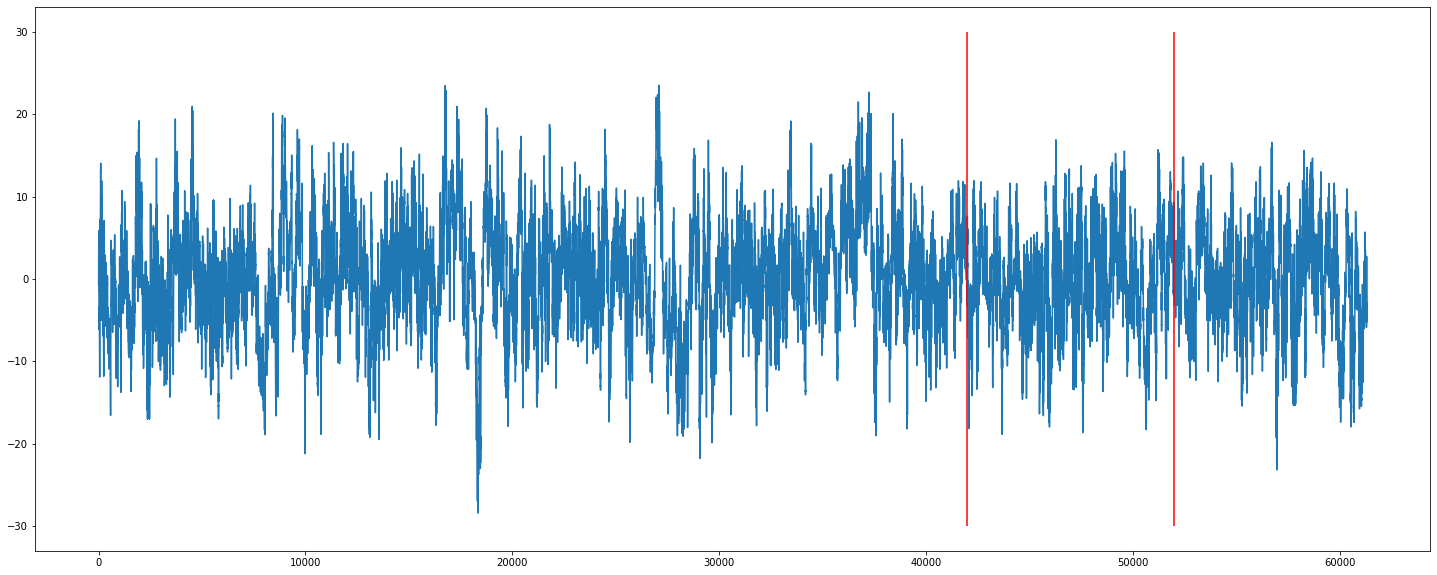

In [87]:
X_train1, y_train1 = X1[:42000], y1[:42000]
X_val1, y_val1 = X1[42000:52000], y1[42000:52000]
X_test1, y_test1 = X1[52000:], y1[52000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

fig, ax = plt.subplots(1,figsize=(25,10))
plt.plot(y1)
plt.vlines(42000,-30,30,'r')
plt.vlines(52000,-30,30, 'r')

### Optional: Normierung der Daten

In [88]:
'''
X_train2, y_train2 = X1[:42000], y1[:42000]
X_val2, y_val2 = X1[42000:52000], y1[42000:52000]
X_test2, y_test2 = X1[52000:], y1[52000:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

temp_training_mean = np.mean(X_train2[:, :, 0])
temp_training_std = np.std(X_train2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)
'''

'\nX_train2, y_train2 = X1[:42000], y1[:42000]\nX_val2, y_val2 = X1[42000:52000], y1[42000:52000]\nX_test2, y_test2 = X1[52000:], y1[52000:]\nX_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape\n\ntemp_training_mean = np.mean(X_train2[:, :, 0])\ntemp_training_std = np.std(X_train2[:, :, 0])\n                           \ndef preprocess(X):\n  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std\n  return X\n\npreprocess(X_train2)\npreprocess(X_val2)\npreprocess(X_test2)\n'

# Modellierung

### Modell 1: Random Walk (Stochastische Irrfahrt)

In [89]:
def random_walk_model(X, WINDOW_SIZE):
    return X[:,WINDOW_SIZE-1,:]

y_random_walk = random_walk_model(X_test1,WINDOW_SIZE)

print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),y_random_walk.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),y_random_walk.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),y_random_walk.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),y_random_walk.squeeze())))

RMSE= 1.051197214805854
MSE= 1.1050155844155845
MAE= 0.7497026940002146
R2= 0.9695157241138498


### Modell 2: Autoregression AR(p)

In [90]:
# Iteriere über eine maximale Verögerungsstruktur von p=1,...,50

autoreg_model = []
MSE = []
pred = []
for i in range(WINDOW_SIZE):
    autoreg = linear_model.LinearRegression().fit(X_train1.squeeze()[:,(WINDOW_SIZE-i-1):WINDOW_SIZE],y_train1.squeeze())
    MSE.append(mean_squared_error(y_val1.squeeze(),autoreg.predict(X_val1.squeeze()[:,(WINDOW_SIZE-i-1):WINDOW_SIZE]),squared=False))
    autoreg_model.append(autoreg)
    pred.append(autoreg.predict(X_val1.squeeze()[:,(WINDOW_SIZE-i-1):WINDOW_SIZE]))

In [91]:
# Optimales p
np.argmin(MSE)

24

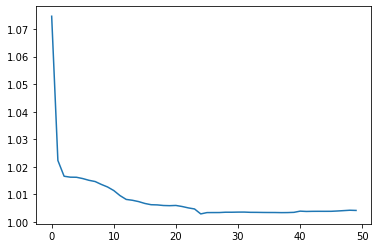

In [92]:
# Darstellung des mitterlen quadratischen Fehlers (MSE) für die Validierungsdaten
plt.plot(MSE)

In [93]:
pred_test_autoreg =autoreg_model[np.argmin(MSE)].predict(X_test1.squeeze()[:,(WINDOW_SIZE-np.argmin(MSE)-1):WINDOW_SIZE])

print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),pred_test_autoreg.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),pred_test_autoreg.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),pred_test_autoreg.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),pred_test_autoreg.squeeze())))

RMSE= 0.9805106950371495
MSE= 0.9614012230822341
MAE= 0.6938113437061612
R2= 0.9734776409174165


## Modell 3: Multilayer Perceptron mit verzögerten Eingangsgrößen (lagged MLP)

In [94]:
# Definition des Modell

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE)))
model1.add(Dense(32, 'relu'))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                1632      
                                                                 
 dense_20 (Dense)            (None, 8)                 264       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,905
Trainable params: 1,905
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Definition von Checkpoints um das beste Modell auf den Validierungsdaten zu speichern

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
# Schätzung des Modells

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

In [97]:
model1 = load_model('model1/')
pred_test_dnn=model1.predict(X_test1)
print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),pred_test_dnn.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),pred_test_dnn.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),pred_test_dnn.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),pred_test_dnn.squeeze())))

RMSE= 1.0083947999568674
MSE= 1.0168600725800505
MAE= 0.7169180161765593
R2= 0.9719476870486535


### Modell 3: Rekurrentes Neuronales Netz

In [98]:
# Definition des Modells

model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(SimpleRNN(32))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Definition von Checkpoints um das beste Modell auf den Validierungsdaten zu speichern

cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
#Schätzung des Modells

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

In [101]:
# Evaluierung des Modells

model2 = load_model('model2/')
pred_test_rnn=model2.predict(X_test1)
print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),pred_test_rnn.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),pred_test_rnn.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),pred_test_rnn.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),pred_test_rnn.squeeze())))

RMSE= 0.9909567066699744
MSE= 0.9819951944942016
MAE= 0.7004181445734087
R2= 0.9729095110964728


## Bonus Sessions

### Schätzung mit einem LSTM Modells

In [ ]:
model3 = Sequential()
model3.add(InputLayer((WINDOW_SIZE, 1)))
model3.add(LSTM(32))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp3])

In [103]:
model3 = load_model('model3/')

pred_test_lstm=model3.predict(X_test1)
print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),pred_test_lstm.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),pred_test_lstm.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),pred_test_lstm.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),pred_test_lstm.squeeze())))

RMSE= 0.9824718113175808
MSE= 0.9652508600336481
MAE= 0.695292959035249
R2= 0.9733714402479023


## Schätzung mit einem 1-D Convolutional Modells

In [104]:
model4 = Sequential()
model4.add(InputLayer((WINDOW_SIZE, 1)))
model4.add(Conv1D(32, kernel_size=2))
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 49, 32)            96        
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_26 (Dense)            (None, 8)                 12552     
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12,657
Trainable params: 12,657
Non-trainable params: 0
_________________________________________________________________


In [105]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp4])

In [107]:
model4 = load_model('model4/')

pred_test_conv=model4.predict(X_test1)
print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),pred_test_conv.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),pred_test_conv.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),pred_test_conv.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),pred_test_conv.squeeze())))

RMSE= 0.9892829841794539
MSE= 0.9786808227870056
MAE= 0.7051206199323533
R2= 0.973000945301507


## Schätzung mit einem RRU Modell

In [108]:
model5 = Sequential()
model5.add(InputLayer((WINDOW_SIZE, 1)))
model5.add(GRU(32))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                3360      
                                                                 
 dense_28 (Dense)            (None, 8)                 264       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,633
Trainable params: 3,633
Non-trainable params: 0
_________________________________________________________________


In [109]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model5.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp5])

In [111]:
model5 = load_model('model5/')

pred_test_gru=model5.predict(X_test1)
print('RMSE= '+ str(mean_squared_error(y_test1.squeeze(),pred_test_gru.squeeze(), squared=False)))
print('MSE= ' + str(mean_squared_error(y_test1.squeeze(),pred_test_gru.squeeze(), squared=True)))
print('MAE= ' + str(mean_absolute_error(y_test1.squeeze(),pred_test_gru.squeeze())))
print('R2= ' + str(r2_score(y_test1.squeeze(),pred_test_gru.squeeze())))

RMSE= 0.984231090357009
MSE= 0.9687108392253467
MAE= 0.6955744277083645
R2= 0.9732759891413952
